# SIS on Scale Free Network

**tested on:**

windows 10 x86_64 version 1909  
python      3.7  
networkx    2.4  
numpy       1.18.1  
matplotlib  3.1.3  
ndlib       5.0.2  
bokeh       1.4.0  

SIS epidemic is simulated using  [ndlib](https://github.com/GiulioRossetti/ndlib)

In [1]:
import collections
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.utils import powerlaw_sequence   # to create power law degree sequence

# random number generator
from datetime import datetime
random.seed(datetime.now())

## Create Scale-free graph

graph has 1000 nodes and 3479 edges


Text(0.5, 1.0, 'degree distribution')

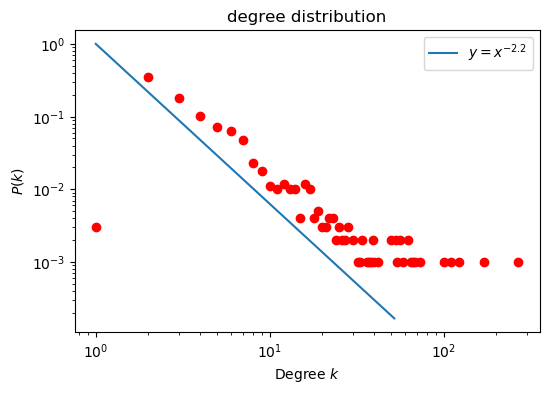

In [4]:
num_nodes = 1000  # number of nodes
exp = 2.2         # exponent of power law distribution

# random power law degree sequence
sequence = []
while len(sequence) < num_nodes:
    nextval = int(powerlaw_sequence(1, exp)[0])
    # we throw away nodes with degree more than num_nodes/2
    # also we set min degree to 2. because this methods creates too many parallel edges
    # that we need to remove
    if 2 <= nextval <= (num_nodes // 2):
        sequence.append(nextval)

# sum of degrees must even
if sum(sequence) % 2 == 1:
    sequence[0] += 1

# create multigraph
graph = nx.configuration_model(sequence)
# remove parallel edges
graph = nx.Graph(graph)
# remove self loops
loops = nx.selfloop_edges(graph)
graph.remove_edges_from(loops)

# get largest connected component
largest_cc = max(nx.connected_components(graph), key=len)
graph = graph.subgraph(largest_cc).copy()

print("graph has {0:d} nodes and {1:d} edges".format(nx.number_of_nodes(graph),
                                                     nx.number_of_edges(graph)))

# plot degree distribution
degree_list = [graph.degree(n) for n in graph]
degreeCount = collections.Counter(degree_list)
degree, counts = zip(*degreeCount.items())
plt.figure(num=None, dpi=100, facecolor='w', edgecolor='k')
plt.plot(degree, np.array(counts) / num_nodes, 'ro')

# plot y = x^(-exp) to compare it to our data
x = np.arange(1, len(counts))
label = ("$y = x^{{{}}}$").format(-exp)
plt.plot(x, np.power(x, -exp), label=label)

# set axis to log-log
plt.xlabel(r"Degree $k$")
plt.xscale("log")
plt.ylabel(r"$P(k)$")
plt.yscale("log")
plt.legend(loc="best")
plt.title(r"degree distribution")

## Run SIS simulation

In [5]:
# Simulate SIS
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep

# plot SIS results
from bokeh.io import show, output_notebook
from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend

In [6]:
# to display SIS results plot inline in noteboook
output_notebook() 

Loading BokehJS ...

### a) Plot fractions of infected and susceptible nodes in terms of time
for infection rate $\beta = 0.1$ and recovery rate $\mu = 1$

In [7]:
# Model selection
model = ep.SISModel(graph)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.2)
cfg.add_model_parameter('lambda', 1)
cfg.add_model_parameter("fraction_infected", 0.05)
model.set_initial_status(cfg)

# Simulation execution
iterations = model.iteration_bunch(200)
trends = model.build_trends(iterations)

# plot fractions of infected and susceptible nodes in terms of time
viz = DiffusionTrend(model, trends)
p = viz.plot(width=600, height=600)
show(p)

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 234.02it/s]


### b) Find the fraction of infected nodes at the stationary state

In [8]:
# list of number of infected nodes in last 30 iterations
list_num_inf =[]
for i in range(-30, 0):
    list_num_inf.append(iterations[i]["node_count"][1])
list_num_inf = np.array(list_num_inf)

# list of fraction of infected nodes in last 30 iterations
list_frac_inf = np.divide(list_num_inf, num_nodes)

# mean and standard deviation of (fraction of infected nodes) in last 30 iterations
# standard deviation is used as a measure of fluctuations in stationary state
mean_inf = np.mean(list_frac_inf)
fluctuation_inf = np.std(list_frac_inf, axis=0)

print("farction of infected nodes at stationary state is: {0:.5f}".format(mean_inf))
print("with standard deviation: {0:.5f}".format(fluctuation_inf))

farction of infected nodes at stationary state is: 0.22513
with standard deviation: 0.01137


### c) plot the stationary value of infected nodes in terms of beta

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 210.41it/s]


Text(0, 0.5, 'fraction infected at stationary')

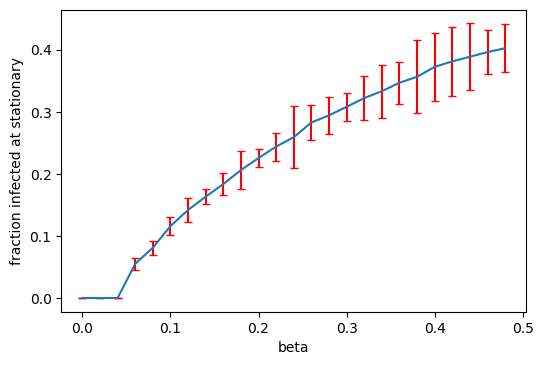

In [10]:
range_beta = np.arange(0.0, 0.5, 0.02)
inf_vs_beta = []    # inf fraction vs beta
fluctuation_vs_beta =[]

for beta in range_beta:
    # Model selection
    model = ep.SISModel(graph)

    # Model Configuration
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta)
    cfg.add_model_parameter('lambda', 1)
    cfg.add_model_parameter("fraction_infected", 0.05)
    model.set_initial_status(cfg)

    # Simulation execution
    iterations = model.iteration_bunch(200)

    # list of number of infected nodes in last 30 iterations
    list_num_inf = []
    for i in range(-30, 0):
        list_num_inf.append(iterations[i]["node_count"][1])
    list_num_inf = np.array(list_num_inf)

    # list of fraction of infected nodes in last 30 iterations
    list_frac_inf = np.divide(list_num_inf, num_nodes)

    # mean and standard deviation of (fraction of infected nodes) in last 30 iterations
    # standard deviation is used as a measure of fluctuations in stationary state
    mean_inf = np.mean(list_frac_inf)
    fluctuation_inf = np.std(list_frac_inf, axis=0)

    # add mean value to inf vs beta list
    inf_vs_beta.append(mean_inf)
    # add std value to error list
    fluctuation_vs_beta.append(fluctuation_inf)

# plot inf fraction vs beta with fluctuations
plt.figure(num=None, dpi=100, facecolor='w', edgecolor='k')
plt.errorbar(range_beta, inf_vs_beta , yerr=fluctuation_vs_beta, ecolor="red", capsize=3)
plt.xlabel(r"beta")
plt.ylabel(r"fraction infected at stationary")